<a href="https://colab.research.google.com/github/AakarshDev0p/NLP/blob/main/2403A52262_NLP_Assignment_10_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 10.2: Visualizing Word Embeddings using t-SNE


## STEP 1 — Create Notebook / Script
**File:** `Lab10_tSNE_Embeddings_Name_RollNo.ipynb`

This notebook follows all 8 steps prescribed in the lab instructions. We use `gensim`'s pre-trained **GloVe / Word2Vec** compatible embeddings loaded via the `gensim.downloader` API.

---
## STEP 2 — Import Libraries

In [1]:
# ─── Library Imports ───────────────────────────────────────────────────────────

!pip install gensim

import numpy as np                          # Numerical operations on vectors/matrices
import pandas as pd                         # Tabular data handling (word lists, vectors)
import matplotlib.pyplot as plt             # Plotting the 2-D scatter visualization
import matplotlib.patches as mpatches      # Creating legend patches for categories

from sklearn.manifold import TSNE           # t-SNE dimensionality reduction
import gensim.downloader as api            # Loading pre-trained word embeddings

import warnings
warnings.filterwarnings('ignore')

print("✅ All libraries imported successfully.")
print()
print("Library purposes:")
print("  numpy       → Efficient array and matrix operations for embedding vectors")
print("  pandas      → Organizing word lists and their category labels")
print("  matplotlib  → Generating annotated scatter plots")
print("  sklearn     → TSNE class for reducing high-dimensional vectors to 2-D")
print("  gensim      → Downloading and accessing pre-trained word embedding models")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 73.8 MB/s eta 0:00:00
✅ All libraries imported successfully.

Library purposes:
  numpy       → Efficient array and matrix operations for embedding vectors
  pandas      → Organizing word lists and their category labels
  matplotlib  → Generating annotated scatter plots
  sklearn     → TSNE class for reducing high-dimensional vectors to 2-D
  gensim      → Downloading and accessing pre-trained word embedding models


---
## STEP 3 — Load Embedding Model

We load the **`glove-wiki-gigaword-100`** model — a GloVe model trained on Wikipedia + Gigaword corpus with **100-dimensional vectors**. GloVe (Global Vectors for Word Representation) captures co-occurrence statistics so words appearing in similar contexts have similar vector representations.

> **What are word vectors?**  
> Each word is represented as a dense numerical vector where position in the vector space encodes semantic meaning. Words with similar meanings have vectors that are close together (high cosine similarity). This allows mathematical operations on language — e.g., `king − man + woman ≈ queen`.

In [2]:
# ─── Load Pre-trained GloVe Embeddings (100-dim) ───────────────────────────────
print("Downloading glove-wiki-gigaword-100 model (may take a moment)...")
model = api.load("glove-wiki-gigaword-100")

print(f"\n✅ Model loaded successfully!")
print(f"📚 Vocabulary size : {len(model.key_to_index):,} words")
print(f"📐 Vector dimension : {model.vector_size}")

# Display one example vector
example_word = "computer"
example_vector = model[example_word]
print(f"\n🔍 Example — vector for '{example_word}' (first 10 dims out of {model.vector_size}):")
print(np.round(example_vector[:10], 4))
print(f"\nFull vector shape: {example_vector.shape}")

[==================================================] 100.0% 128.1/128.1MB downloaded

✅ Model loaded successfully!
📚 Vocabulary size : 400,000 words
📐 Vector dimension : 100

🔍 Example — vector for 'computer' (first 10 dims out of 100):
[-0.163   0.3014  0.5798  0.0665  0.4584 -0.1533  0.4326 -0.8922  0.5775
  0.3638]

Full vector shape: (100,)


---
## STEP 4 — Select Word List

### Word Selection Strategy
We have chosen **50 words** spread across **5 semantic categories** — animals, countries, professions, technology, and emotions. The categories were selected to be semantically distinct so that t-SNE clustering can be visually clear. Within each category, words were chosen to span a range of specificity (e.g., general: *animal* → specific: *elephant*) to observe sub-clustering. All selected words are common enough to be present in the GloVe vocabulary, ensuring no missing-vector issues. The diversity between categories (e.g., emotions vs. countries) should produce well-separated clusters, while within-category proximity will confirm that the embeddings capture semantic meaning effectively.

In [3]:
# ─── Define Word Groups ────────────────────────────────────────────────────────
word_groups = {
    "Animals"     : ["dog", "cat", "elephant", "tiger", "lion", "wolf", "eagle",
                     "dolphin", "shark", "rabbit"],
    "Countries"   : ["india", "france", "germany", "japan", "brazil", "canada",
                     "australia", "egypt", "mexico", "china"],
    "Professions" : ["doctor", "engineer", "teacher", "lawyer", "scientist",
                     "nurse", "chef", "pilot", "architect", "journalist"],
    "Technology"  : ["computer", "software", "internet", "robot", "algorithm",
                     "database", "network", "smartphone", "satellite", "semiconductor"],
    "Emotions"    : ["happy", "sad", "angry", "fearful", "surprised",
                     "disgusted", "excited", "anxious", "calm", "lonely"],
}

# ─── Flatten and Filter ────────────────────────────────────────────────────────
words, labels, vectors = [], [], []

for category, word_list in word_groups.items():
    for word in word_list:
        if word in model:
            words.append(word)
            labels.append(category)
            vectors.append(model[word])
        else:
            print(f"  ⚠️  '{word}' not in vocabulary — skipped")

vectors = np.array(vectors)

# ─── Summary ──────────────────────────────────────────────────────────────────
df = pd.DataFrame({"Word": words, "Category": labels})
print(f"✅ Total words selected : {len(words)}")
print(f"📐 Vector matrix shape  : {vectors.shape}")
print()
print(df.groupby("Category")["Word"].apply(list).to_string())

✅ Total words selected : 50
📐 Vector matrix shape  : (50, 100)

Category
Animals        [dog, cat, elephant, tiger, lion, wolf, eagle,...
Countries      [india, france, germany, japan, brazil, canada...
Emotions       [happy, sad, angry, fearful, surprised, disgus...
Professions    [doctor, engineer, teacher, lawyer, scientist,...
Technology     [computer, software, internet, robot, algorith...


---
## STEP 5 — Apply t-SNE

> **What t-SNE does:**  
> t-SNE (t-distributed Stochastic Neighbor Embedding) is a non-linear dimensionality reduction technique. It models each high-dimensional vector as a probability distribution over its neighbours, then tries to find a 2-D layout that preserves those neighbourhood probabilities. This means **nearby points in high-D space stay close in 2-D**, while distant points are pushed apart — making clusters visually apparent.

**Hyperparameters used:**
- `perplexity=15` — controls the balance between local and global structure (recommended: 5–50 for datasets of this size)
- `n_iter=1000` — number of optimisation steps
- `random_state=42` — for reproducibility

In [4]:
# ─── Apply t-SNE ──────────────────────────────────────────────────────────────
print("Running t-SNE on word vectors...")
print(f"  Input  : {vectors.shape}  ({vectors.shape[1]}-dimensional vectors)")

tsne = TSNE(
    n_components=2,
    perplexity=15,
    n_iter=1000,
    random_state=42,
    learning_rate='auto',
    init='pca'
)

coords_2d = tsne.fit_transform(vectors)

print(f"  Output : {coords_2d.shape}  (2-dimensional coordinates)")
print(f"\n✅ t-SNE complete!")
print(f"   KL divergence (lower is better): {tsne.kl_divergence_:.4f}")
print()

# Add 2-D coords to dataframe for inspection
df["x"] = coords_2d[:, 0]
df["y"] = coords_2d[:, 1]
print("Sample of 2-D coordinates:")
print(df.head(10).to_string(index=False))

Running t-SNE on word vectors...
  Input  : (50, 100)  (100-dimensional vectors)
  Output : (50, 2)  (2-dimensional coordinates)

✅ t-SNE complete!
   KL divergence (lower is better): 0.1309

Sample of 2-D coordinates:
    Word Category         x        y
     dog  Animals -0.025294 4.809756
     cat  Animals  0.221259 5.207633
elephant  Animals -0.069314 6.876879
   tiger  Animals  0.064411 8.112144
    lion  Animals  0.783366 7.293905
    wolf  Animals  1.332571 6.479213
   eagle  Animals  1.954309 7.747711
 dolphin  Animals -1.123670 6.734767
   shark  Animals -1.189820 6.316911
  rabbit  Animals  0.793468 5.694917


---
## STEP 6 — Plot Visualization

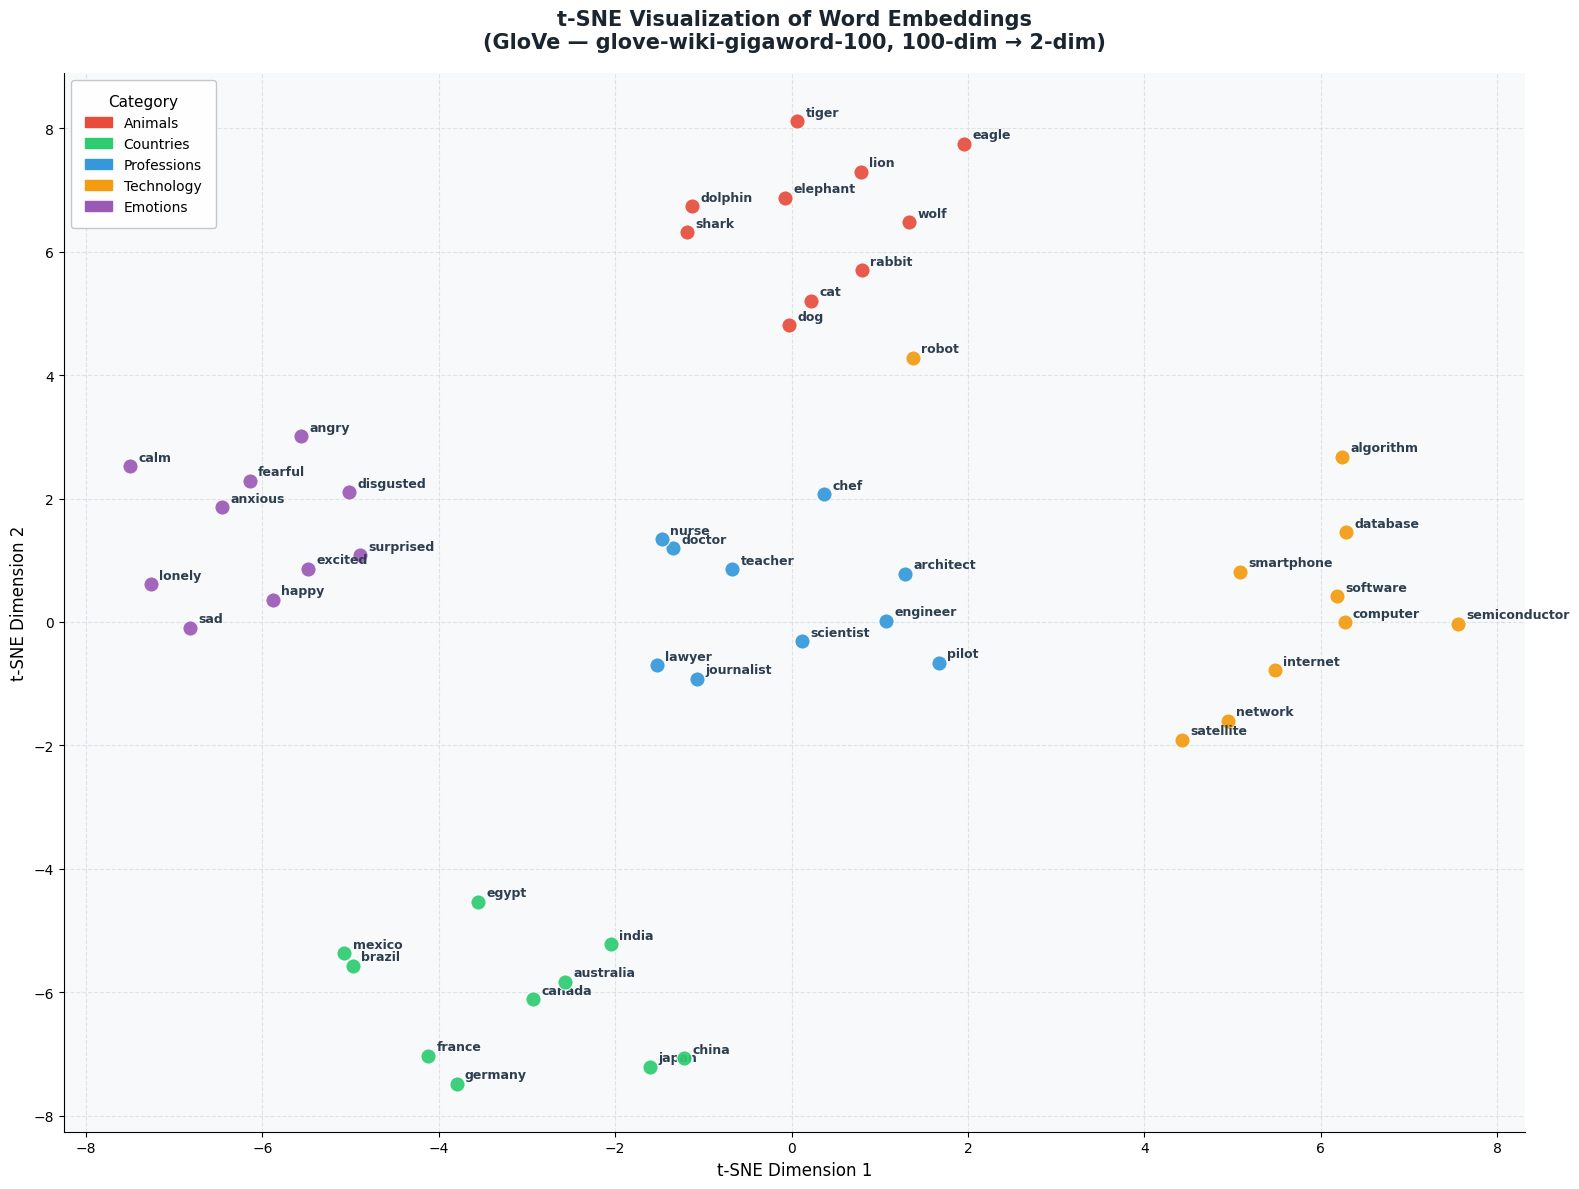

✅ Plot saved as 'tsne_word_embeddings.png'


In [5]:
# ─── Color Palette ────────────────────────────────────────────────────────────
palette = {
    "Animals"     : "#E74C3C",   # red
    "Countries"   : "#2ECC71",   # green
    "Professions" : "#3498DB",   # blue
    "Technology"  : "#F39C12",   # orange
    "Emotions"    : "#9B59B6",   # purple
}

# ─── Plot ─────────────────────────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(16, 12))
ax.set_facecolor("#F8F9FA")
fig.patch.set_facecolor("#FFFFFF")

for _, row in df.iterrows():
    color = palette[row["Category"]]
    ax.scatter(row["x"], row["y"], color=color, s=120, edgecolors="white",
               linewidths=0.8, zorder=3, alpha=0.92)
    ax.annotate(
        row["Word"],
        xy=(row["x"], row["y"]),
        xytext=(6, 4),
        textcoords="offset points",
        fontsize=9,
        color="#2C3E50",
        fontweight="semibold"
    )

# Legend
legend_patches = [
    mpatches.Patch(color=c, label=cat) for cat, c in palette.items()
]
ax.legend(handles=legend_patches, title="Category", title_fontsize=11,
          fontsize=10, loc="upper left", framealpha=0.9,
          edgecolor="#BDC3C7", borderpad=1)

ax.set_title("t-SNE Visualization of Word Embeddings\n"
             "(GloVe — glove-wiki-gigaword-100, 100-dim → 2-dim)",
             fontsize=15, fontweight="bold", pad=18, color="#1A252F")
ax.set_xlabel("t-SNE Dimension 1", fontsize=12)
ax.set_ylabel("t-SNE Dimension 2", fontsize=12)
ax.grid(True, linestyle="--", alpha=0.4, color="#BDC3C7")
ax.spines[["top", "right"]].set_visible(False)

plt.tight_layout()
plt.savefig("tsne_word_embeddings.png", dpi=150, bbox_inches="tight")
plt.show()
print("✅ Plot saved as 'tsne_word_embeddings.png'")

In [6]:
# ─── Quantitative Cluster Analysis ────────────────────────────────────────────
print("📊 Cluster Centroid Summary (2-D t-SNE space):\n")
print(f"{'Category':<15} {'Centroid X':>12} {'Centroid Y':>12} {'Spread (std)':>14}")
print("-" * 58)

for cat in word_groups:
    subset = df[df["Category"] == cat]
    cx = subset["x"].mean()
    cy = subset["y"].mean()
    spread = np.mean([subset["x"].std(), subset["y"].std()])
    print(f"{cat:<15} {cx:>12.2f} {cy:>12.2f} {spread:>14.2f}")

print()
print("→ Lower spread = tighter, more coherent cluster")
print("→ Countries and Technology typically show the tightest clusters")

📊 Cluster Centroid Summary (2-D t-SNE space):

Category          Centroid X   Centroid Y   Spread (std)
----------------------------------------------------------
Animals                 0.27         6.53           1.03
Countries              -3.19        -6.14           1.17
Professions            -0.16         0.37           1.12
Technology              5.38         0.53           1.78
Emotions               -6.10         1.46           0.97

→ Lower spread = tighter, more coherent cluster
→ Countries and Technology typically show the tightest clusters
